# Test et comparaisons de nos modèles

In [1]:
import time

t_debut = time.time()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from tools import datasets, convert_keys_to_int

Importation de la liste des variables explicatives sélectionnées, des meilleurs paramètres et du seuil ajusté pour chaque modèle.

In [2]:
best_LR = "LR_RFECV"
best_RF = "Forest_RFECV"
best_XGB = "XGBoost_RFECV"

In [3]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)[best_LR]
    LR_PARAMS = convert_keys_to_int(LR_PARAMS)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêt aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    RF_COLUMNS = json.load(column_file)
    RF_COLUMNS_QUANT = RF_COLUMNS['columns_quant']
    RF_COLUMNS_CAT = RF_COLUMNS['columns_cat']
    RF_COLUMNS = RF_COLUMNS_QUANT + RF_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    RF_PARAMS = json.load(param_file)[best_RF]
    RF_PARAMS = convert_keys_to_int(RF_PARAMS)

print(f'Variables explicatives forêt aléatoires ({len(RF_COLUMNS)}) :')
display(RF_COLUMNS)

print(f'Meilleurs paramètres forêt aléatoires ({len(RF_PARAMS)}) :')
RF_PARAMS['class_weight'] = {int(k): v for k,v in RF_PARAMS['class_weight'].items()}
display(RF_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XGB_COLUMNS = json.load(column_file)
    XGB_COLUMNS_QUANT = XGB_COLUMNS['columns_quant']
    XGB_COLUMNS_CAT = XGB_COLUMNS['columns_cat']
    XGB_COLUMNS = XGB_COLUMNS_QUANT + XGB_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XGB_PARAMS = json.load(param_file)[best_XGB]
    XGB_PARAMS = convert_keys_to_int(XGB_PARAMS)

print(f'Variables explicatives XGBoost ({len(XGB_COLUMNS)}) :')
display(XGB_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XGB_PARAMS)}) :')
display(XGB_PARAMS)

# Seuils ajustés
with open('backups/THRESHOLD.json') as threshold_file:
    SEUILS = json.load(threshold_file)

print("Seuils ajustés :")
display(SEUILS)

Variables explicatives régression logistique (11) :


['campaignctrlast24h',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'campaignscenario_13',
 'device_type_Desktop',
 'device_type_iPhone',
 'display_env_app_ios',
 'is_interstitial_True',
 'target_env_2']

Meilleurs paramètres régression logistique (2) :


{'C': 0.007278953843983146, 'class_weight': {0: 1, 1: 20}}

Variables explicatives forêt aléatoires (9) :


['campaignctrlast24h',
 'contextid',
 'dayssincelastvisitdouble',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêt aléatoires (8) :


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': False,
 'n_jobs': -1}

Variables explicatives XGBoost (9) :


['campaignctrlast24h',
 'contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Android',
 'device_type_Desktop',
 'device_type_iPad',
 'is_interstitial_True']

Meilleurs paramètres XGBoost (11) :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'n_jobs': -1}

Seuils ajustés :


{'LR': 0.5014648437500001,
 'Forest': 0.6503906250000003,
 'XGBoost': 0.46533203125}

## 1. Régression logistique

In [4]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1)
datasets_df_train = datasets(df_train, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
datasets_df_test = datasets(df_test, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
X_train_LR = datasets_df_train['X_only_quant_scaled']
y_train_LR = datasets_df_train['y']
X_test_LR = datasets_df_test['X_only_quant_scaled']
y_test_LR = datasets_df_test['y']

In [5]:
%%time
clf_LR = LogisticRegression(**LR_PARAMS)
t = time.time()
clf_LR.fit(X_train_LR, y_train_LR)
train_time_LR = time.time() - t

CPU times: user 38.2 s, sys: 1min 34s, total: 2min 12s
Wall time: 2.88 s


In [6]:
def final_predictor_LR(X):
    y_probas = clf_LR.predict_proba(X)[:, 1]
    return (y_probas >= SEUILS['LR']) * 1

Matrice de confusion

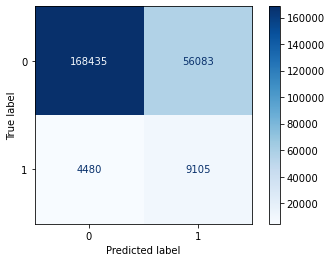

In [7]:
y_pred = final_predictor_LR(X_test_LR)
cm = confusion_matrix(y_test_LR, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Courbe ROC

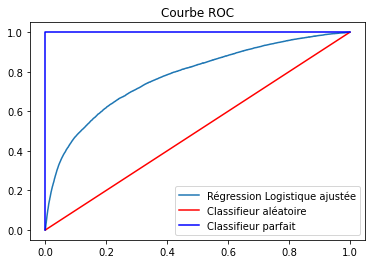

In [8]:
y_probas = clf_LR.predict_proba(X_test_LR)[:, 1]
fpr, tpr, _ = roc_curve(y_test_LR, y_probas)
plt.plot(fpr, tpr, label=f"Régression Logistique ajustée")
plt.plot([0, 1], [0, 1], "r-", label='Classifieur aléatoire')
plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Classifieur parfait')
plt.legend()
plt.title('Courbe ROC')
plt.show()

Métriques

In [9]:
t = time.time()
y_pred = final_predictor_LR(X_test_LR)
pred_time_LR = time.time() - t
recall, precision = recall_score(y_test_LR, y_pred), precision_score(y_test_LR, y_pred)

METRIQUES_LR = pd.DataFrame({"Modèle": "Régression logistique",
    "Précicion": [precision],
    "Rappel": [recall],
    "Score F1": [(2 * precision * recall) / (precision + recall)],
    "Score F3": [(10 * precision * recall) / (9 * precision + recall)],
    "Score F5": [(26 * precision * recall) / (25 * precision + recall)],
    "Aire sous la courbe ROC": [roc_auc_score(y_test_LR, y_pred)],
    "Durée d'apprentissage": [train_time_LR],
    "Durée de prédiction": [pred_time_LR]}).set_index("Modèle")

METRIQUES_LR

,Précicion,Rappel,Score F1,Score F3,Score F5,Aire sous la courbe ROC,Durée d'apprentissage,Durée de prédiction
Modèle,,,,,,,,
Régression logistique,0.139673,0.670225,0.231171,0.485722,0.584789,0.710216,2.88178,0.011863


## 2. Random Forest

In [10]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1)
datasets_df_train = datasets(df_train, columns_quant=RF_COLUMNS_QUANT, columns_cat=RF_COLUMNS_CAT, verbose=False)
datasets_df_test = datasets(df_test, columns_quant=RF_COLUMNS_QUANT, columns_cat=RF_COLUMNS_CAT, verbose=False)
X_train_RF = datasets_df_train['X']
y_train_RF = datasets_df_train['y']
X_test_RF = datasets_df_test['X']
y_test_RF = datasets_df_test['y']

In [11]:
%%time
clf_RF = RandomForestClassifier(**RF_PARAMS)
t = time.time()
clf_RF.fit(X_train_RF, y_train_RF)
train_time_RF = time.time() - t

CPU times: user 1h 36min 53s, sys: 21 s, total: 1h 37min 14s
Wall time: 1min 55s


In [12]:
def final_predictor_RF(X):
    y_probas = clf_RF.predict_proba(X)[:, 1]
    return (y_probas >= SEUILS['Forest']) * 1

Matrice de confusion

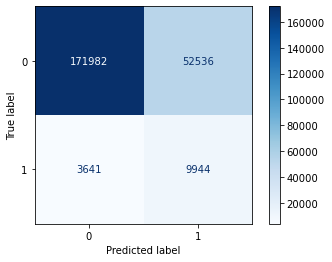

In [13]:
y_pred = final_predictor_RF(X_test_RF)
cm = confusion_matrix(y_test_RF, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Courbe ROC

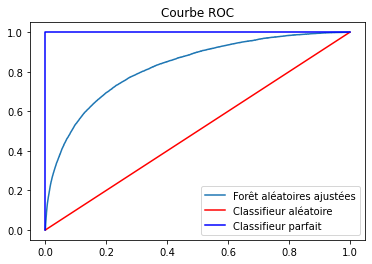

In [14]:
y_probas = clf_RF.predict_proba(X_test_RF)[:, 1]
fpr, tpr, _ = roc_curve(y_test_RF, y_probas)
plt.plot(fpr, tpr, label=f"Forêt aléatoires ajustées")
plt.plot([0, 1], [0, 1], "r-", label='Classifieur aléatoire')
plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Classifieur parfait')
plt.legend()
plt.title('Courbe ROC')
plt.show()

Métriques

In [15]:
t = time.time()
y_pred = final_predictor_RF(X_test_RF)
pred_time_RF = time.time() - t
recall, precision = recall_score(y_test_RF, y_pred), precision_score(y_test_RF, y_pred)

METRIQUES_RF = pd.DataFrame({"Modèle": "Forêt aléatoires",
    "Précicion": [precision],
    "Rappel": [recall],
    "Score F1": [(2 * precision * recall) / (precision + recall)],
    "Score F3": [(10 * precision * recall) / (9 * precision + recall)],
    "Score F5": [(26 * precision * recall) / (25 * precision + recall)],
    "Aire sous la courbe ROC": [roc_auc_score(y_test_RF, y_pred)],
    "Durée d'apprentissage": [train_time_RF],
    "Durée de prédiction": [pred_time_RF]}).set_index("Modèle")

METRIQUES_RF

,Précicion,Rappel,Score F1,Score F3,Score F5,Aire sous la courbe ROC,Durée d'apprentissage,Durée de prédiction
Modèle,,,,,,,,
Forêt aléatoires,0.159155,0.731984,0.261461,0.538255,0.642976,0.748995,115.162244,0.642656


## 3. XGBoost

In [16]:
df_train = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1)
datasets_df_train = datasets(df_train, columns_quant=XGB_COLUMNS_QUANT, columns_cat=XGB_COLUMNS_CAT, verbose=False)
datasets_df_test = datasets(df_test, columns_quant=XGB_COLUMNS_QUANT, columns_cat=XGB_COLUMNS_CAT, verbose=False)
X_train_XGB = datasets_df_train['X']
y_train_XGB = datasets_df_train['y']
X_test_XGB = datasets_df_test['X']
y_test_XGB = datasets_df_test['y']

In [17]:
%%time
clf_XGB = XGBClassifier(**XGB_PARAMS)
t = time.time()
clf_XGB.fit(X_train_XGB, y_train_XGB)
train_time_XGB = time.time() - t

CPU times: user 6min 12s, sys: 1.35 s, total: 6min 13s
Wall time: 13.9 s


In [18]:
def final_predictor_XGB(X):
    y_probas = clf_XGB.predict_proba(X)[:, 1]
    return (y_probas >= SEUILS['XGBoost']) * 1

Matrice de confusion

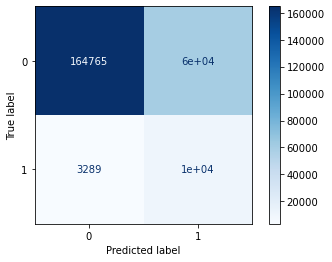

In [19]:
y_pred = final_predictor_XGB(X_test_XGB)
cm = confusion_matrix(y_test_XGB, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Courbe ROC

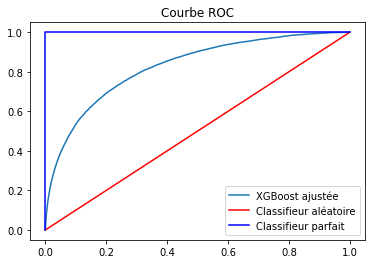

In [20]:
y_probas = clf_XGB.predict_proba(X_test_XGB)[:, 1]
fpr, tpr, _ = roc_curve(y_test_XGB, y_probas)
plt.plot(fpr, tpr, label=f"XGBoost ajustée")
plt.plot([0, 1], [0, 1], "r-", label='Classifieur aléatoire')
plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Classifieur parfait')
plt.legend()
plt.title('Courbe ROC')
plt.show()

Métriques

In [21]:
t = time.time()
y_pred = final_predictor_XGB(X_test_XGB)
pred_time_XGB = time.time() - t
recall, precision = recall_score(y_test_XGB, y_pred), precision_score(y_test_XGB, y_pred)

METRIQUES_XGB = pd.DataFrame({"Modèle": "XGBoost",
    "Précicion": [precision],
    "Rappel": [recall],
    "Score F1": [(2 * precision * recall) / (precision + recall)],
    "Score F3": [(10 * precision * recall) / (9 * precision + recall)],
    "Score F5": [(26 * precision * recall) / (25 * precision + recall)],
    "Aire sous la courbe ROC": [roc_auc_score(y_test_XGB, y_pred)],
    "Durée d'apprentissage": [train_time_XGB],
    "Durée de prédiction": [pred_time_XGB]}).set_index("Modèle")

METRIQUES_XGB

,Précicion,Rappel,Score F1,Score F3,Score F5,Aire sous la courbe ROC,Durée d'apprentissage,Durée de prédiction
Modèle,,,,,,,,
XGBoost,0.146983,0.757895,0.246216,0.535374,0.653437,0.745878,13.909576,0.058849


## 4. Tableau récapitulatif

Modèles classés par F3.

In [22]:
RESULTATS = pd.concat([METRIQUES_LR, METRIQUES_RF, METRIQUES_XGB])
RESULTATS.sort_values("Score F3", ascending=False, inplace=True)
RESULTATS.to_csv('backups/SCORES_comparaison.csv')
a = RESULTATS.columns.tolist()
a.remove("Durée d'apprentissage")
a.remove("Durée de prédiction")
RESULTATS.style.background_gradient(cmap='Blues', subset=a).background_gradient(cmap='Blues_r', subset=["Durée d'apprentissage", "Durée de prédiction"])

,Précicion,Rappel,Score F1,Score F3,Score F5,Aire sous la courbe ROC,Durée d'apprentissage,Durée de prédiction
Modèle,,,,,,,,
Forêt aléatoires,0.159155,0.731984,0.261461,0.538255,0.642976,0.748995,115.162244,0.642656
XGBoost,0.146983,0.757895,0.246216,0.535374,0.653437,0.745878,13.909576,0.058849
Régression logistique,0.139673,0.670225,0.231171,0.485722,0.584789,0.710216,2.881780,0.011863


Considérant la durée de prédiction et le faible écart de score entre les deux meilleurs modèles en termes de F3, le modèle XGBoost est, parmi ces trois modèles, le plus adapté à notre problématique.

In [23]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t_debut))}")

Durée totale d'exécution : 00:03:26
